In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [16]:
class kNN(nn.Module):
    """k-Nearest Neighbors module to construct local graphs"""
    def __init__(self, k=12):
        super(kNN, self).__init__()
        self.k = k
        
    def forward(self, x):
        """
        Input:
            x: point cloud [B, C, N]
        Output:
            idx: indices of k-NN [B, N, k]
        """
        batch_size, _, num_points = x.size()
        
        # Move channel dimension to the end for easier distance calculation
        x = x.transpose(2, 1).contiguous()  # [B, N, C]
        
        # Calculate pairwise distances
        inner = -2 * torch.matmul(x, x.transpose(2, 1))  # [B, N, N]
        xx = torch.sum(x**2, dim=2, keepdim=True)  # [B, N, 1]
        distance = xx + inner + xx.transpose(2, 1)  # [B, N, N]
        
        # Get k nearest neighbors (exclude self)
        _, idx = torch.topk(distance, k=self.k+1, dim=2, largest=False)
        idx = idx[:, :, 1:self.k+1]  # exclude the point itself
        
        return idx


In [17]:
class PMFI(nn.Module):
    """Point-based Multi-scale Feature Interaction module"""
    def __init__(self, in_channels, out_channels, k=20):
        super(PMFI, self).__init__()
        self.k = k
        self.knn = kNN(k=k)
        
        # Multi-scale processing layers
        self.conv_local = nn.Sequential(
            nn.Conv2d(in_channels*2, out_channels//2, kernel_size=1),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU()
        )
        
        self.conv_global = nn.Sequential(
            nn.Conv1d(in_channels, out_channels//2, kernel_size=1),
            nn.BatchNorm1d(out_channels//2),
            nn.ReLU()
        )
        
        # Feature fusion
        self.conv_fusion = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, x):
        """
        Input:
            x: point features [B, C, N]
        Output:
            x: updated features [B, C_out, N]
        """
        batch_size, channels, num_points = x.size()
        
        # Get k-NN indices
        idx = self.knn(x)  # [B, N, k]
        
        # Global feature branch (standard 1x1 conv)
        x_global = self.conv_global(x)  # [B, C_out//2, N]
        
        # Local feature branch (process local neighborhoods)
        # Create neighborhood features
        idx_base = torch.arange(0, batch_size, device=x.device).view(-1, 1, 1) * num_points
        idx = idx + idx_base
        idx = idx.view(-1)
        
        # Reshape features for gathering
        x_flat = x.transpose(2, 1).contiguous().view(-1, channels)  # [B*N, C]
        neighbors = x_flat[idx].view(batch_size, num_points, self.k, channels)  # [B, N, k, C]
        
        # Combine center features with neighbor features
        x_center = x.transpose(2, 1).unsqueeze(2).repeat(1, 1, self.k, 1)  # [B, N, k, C]
        edge_features = torch.cat([x_center, neighbors - x_center], dim=-1)  # [B, N, k, 2C]
        
        # Process local features
        edge_features = edge_features.permute(0, 3, 1, 2).contiguous()  # [B, 2C, N, k]
        x_local = self.conv_local(edge_features)  # [B, C_out//2, N, k]
        x_local = torch.max(x_local, dim=-1)[0]  # Max pooling over k neighbors [B, C_out//2, N]
        
        # Concatenate global and local features
        x = torch.cat([x_global, x_local], dim=1)  # [B, C_out, N]
        
        # Final fusion
        x = self.conv_fusion(x)  # [B, C_out, N]
        
        return x

In [18]:
class EnhancedPointNetFeature(nn.Module):
    def __init__(self, global_feature=True, feature_transform=False):
        super(EnhancedPointNetFeature, self).__init__()
        self.global_feature = global_feature
        self.feature_transform = feature_transform
        
        # Initial feature extraction
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        
        # PMFI modules (multi-scale feature interaction)
        self.pmfi1 = PMFI(64, 64, k=20)
        self.pmfi2 = PMFI(64, 128, k=20)
        
        # Final feature aggregation
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)
        
        # Optional feature transformation
        if self.feature_transform:
            self.fstn = FeatureTransformNet()

    def forward(self, x):
        n_pts = x.size()[2]
        
        # Initial feature embedding
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Optional feature transformation
        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        
        # Multi-scale feature interaction
        x = self.pmfi1(x)  # Enhanced local geometric relationships
        x = self.pmfi2(x)  # Further feature interaction
        
        # Final feature aggregation
        x = self.bn3(self.conv3(x))
        
        # Global max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        
        return x.view(-1, 1024)


class EnhancedPointNetClassification(nn.Module):
    def __init__(self, num_classes=40, feature_transform=False):
        super(EnhancedPointNetClassification, self).__init__()
        
        # Enhanced feature extraction with PMFI
        self.feature_extraction = EnhancedPointNetFeature(
            global_feature=True, 
            feature_transform=feature_transform
        )
        
        # Classification head (unchanged)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Extract enhanced features
        x = self.feature_extraction(x)
        
        # Classification layers (unchanged)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=-1)

class FeatureTransformNet(nn.Module):
    def __init__(self, k=64):
        super(FeatureTransformNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
               # Fully connected layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batch_size = x.size(0)
        
        # Convolutional blocks
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.transpose(1,2).contiguous()
       
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Global max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        
        # Fully connected layers
        x = F.relu(self.bn4(self.fc1(x.squeeze(-1))))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        
        # Create identity matrix
        iden = torch.eye(x.size(-1) // x.size(0)).view(1, -1).repeat(batch_size, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(batch_size, -1, x.size(-1) // batch_size)
        
        return x

In [19]:
class ModelNet40Dataset(torch.utils.data.Dataset):
    def __init__(self, directory, train=True):
        """
        Load ModelNet40 dataset from HDF5 files
        
        Args:
            directory (str): Path to directory containing HDF5 files
            train (bool): Whether to load training or test data
        """
        self.points = []
        self.labels = []
        
        # Find all HDF5 files in the directory
        h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
        
        # Filter files based on train/test
        split_keyword = "train" if train else "test"
        h5_files = [f for f in h5_files if split_keyword in f]
        
        if not h5_files:
            raise ValueError(f"No {split_keyword} files found in {directory}")
            
        print(f"Loading {split_keyword} files: {h5_files}")
        
        for filename in h5_files:
            filepath = os.path.join(directory, filename)
            with h5py.File(filepath, 'r') as f:
                # Assume the first dataset is points, second is labels
                points = f['data'][:]
                labels = f['label'][:]
        
        
                
                self.points.append(points)
                self.labels.append(labels)
        
        # Concatenate data
        self.points = np.concatenate(self.points, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
        
        # Flatten labels
        self.labels = self.labels.squeeze()
        
        # Transpose points to match model input (C, N) format
        self.points = torch.from_numpy(self.points.transpose(0, 2, 1)).float()
        self.labels = torch.from_numpy(self.labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.points[idx], self.labels[idx]

In [20]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for points, labels in train_loader:
        points, labels = points.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(points)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        total_loss += loss.item()

    return total_loss / len(train_loader), correct / total_samples

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for points, labels in val_loader:
            points, labels = points.to(device), labels.to(device)
            
            outputs = model(points)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            total_loss += loss.item()

    return total_loss / len(val_loader), correct / total_samples

In [21]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for points, labels in train_loader:
        points, labels = points.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(points)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        total_loss += loss.item()

    return total_loss / len(train_loader), correct / total_samples

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for points, labels in val_loader:
            points, labels = points.to(device), labels.to(device)
            
            outputs = model(points)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            total_loss += loss.item()

    return total_loss / len(val_loader), correct / total_samples

def main():
    # Hyperparameters
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 100
    num_classes = 40

    # Device configuration
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Dataset paths (adjust as needed)
    #dataset_paths = [
        #'/kaggle/input/modelnet-40-dataset/modelnet-40-dataset',
        #'/content/modelnet-40-dataset',
        #'.'  # Current directory
        #/kaggle/input/modelnet-40-dataset
        
    #]

    # Find a valid dataset path
    #dataset_path = None
    #for path in dataset_paths:
        #if os.path.exists(path):
            #dataset_path = path
            #break

    #if not dataset_path:
        #raise ValueError("Could not find ModelNet40 dataset")

    # Create datasets
    dataset_path='/kaggle/input/modelnet-40-dataset/modelnet-40-dataset'
    train_dataset = ModelNet40Dataset(dataset_path, train=True)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0
    )

    # Initialize model
    model =EnhancedPointNetClassification(num_classes=num_classes).to(device)

    # Loss and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    # Training loop
    print("Starting training...")
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        
        # Step the learning rate scheduler
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')

    print("Training complete!")

    # Save the model
    torch.save(model.state_dict(), 'pointnet_modelnet40.pth')
    print("Model saved to pointnet_modelnet40.pth")

if __name__ == '__main__':
    main()

Using device: cuda:0
Loading train files: ['ply_data_train3.h5', 'ply_data_train4.h5', 'ply_data_train1.h5', 'ply_data_train0.h5', 'ply_data_train2.h5']
Starting training...
Epoch [1/100]
Train Loss: 1.1631, Train Accuracy: 0.6937
Epoch [2/100]
Train Loss: 0.6138, Train Accuracy: 0.8169
Epoch [3/100]
Train Loss: 0.4900, Train Accuracy: 0.8520
Epoch [4/100]
Train Loss: 0.4171, Train Accuracy: 0.8682
Epoch [5/100]
Train Loss: 0.3867, Train Accuracy: 0.8770
Epoch [6/100]
Train Loss: 0.3475, Train Accuracy: 0.8879
Epoch [7/100]
Train Loss: 0.3107, Train Accuracy: 0.8999
Epoch [8/100]
Train Loss: 0.2983, Train Accuracy: 0.8986
Epoch [9/100]
Train Loss: 0.2745, Train Accuracy: 0.9114
Epoch [10/100]
Train Loss: 0.2649, Train Accuracy: 0.9105
Epoch [11/100]
Train Loss: 0.2475, Train Accuracy: 0.9174
Epoch [12/100]
Train Loss: 0.2251, Train Accuracy: 0.9203
Epoch [13/100]
Train Loss: 0.2208, Train Accuracy: 0.9267
Epoch [14/100]
Train Loss: 0.2030, Train Accuracy: 0.9307
Epoch [15/100]
Train Lo

/tmp/ipykernel_31/2679911772.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pointnet_modelnet40.pth'))


Loading test files: ['ply_data_test1.h5', 'ply_data_test0.h5']
Testing the model...


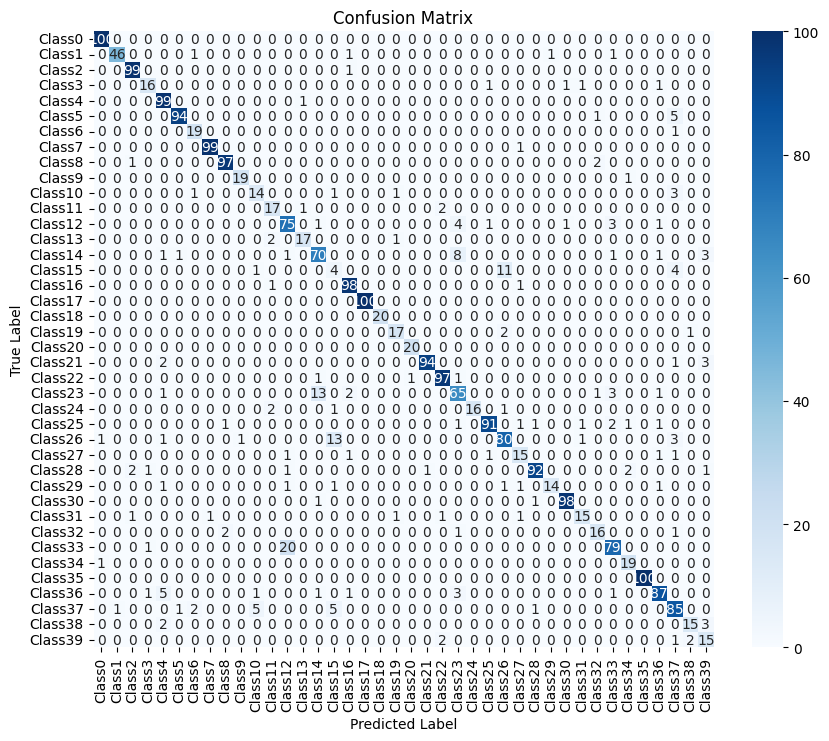

Test Accuracy: 0.9048

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.98      0.92      0.95        50
           2       0.96      0.99      0.98       100
           3       0.84      0.80      0.82        20
           4       0.88      0.99      0.93       100
           5       0.98      0.94      0.96       100
           6       0.83      0.95      0.88        20
           7       0.99      0.99      0.99       100
           8       0.97      0.97      0.97       100
           9       0.95      0.95      0.95        20
          10       0.67      0.70      0.68        20
          11       0.77      0.85      0.81        20
          12       0.76      0.87      0.81        86
          13       0.89      0.85      0.87        20
          14       0.80      0.81      0.81        86
          15       0.16      0.20      0.18        20
          16       0.94      0.98 

In [23]:
# Assuming the ModelNet40Dataset and PointNetClassification classes are already defined
# from your training code

def test_model(model, test_loader, device):
    """
    Test a trained PointNet model on the test dataset.

    Args:
        model (torch.nn.Module): Trained PointNet model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run testing (cuda/cpu).

    Returns:
        dict: Test metrics including accuracy, confusion matrix, and classification report.
    """
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_ground_truth = []

    with torch.no_grad():  # Disable gradient computation for testing
        for points, labels in test_loader:
            points, labels = points.to(device), labels.to(device)

            # Forward pass
            outputs = model(points)
            _, predicted = torch.max(outputs, 1)

            # Collect predictions and ground truth
            all_predictions.extend(predicted.cpu().numpy())
            all_ground_truth.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_ground_truth, all_predictions)
    conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
    class_report = classification_report(all_ground_truth, all_predictions)

    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }


def visualize_results(metrics, class_names):
    """
    Visualize test results using a confusion matrix.

    Args:
        metrics (dict): Test metrics including confusion matrix.
        class_names (list): List of class names.
    """
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print overall accuracy and classification report
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print("\nClassification Report:\n", metrics['classification_report'])


def main():
    # Load the trained model
    num_classes = 40  # Adjust based on your dataset
    model = EnhancedPointNetClassification(num_classes=num_classes)
    
    # Load the saved weights
    model.load_state_dict(torch.load('pointnet_modelnet40.pth'))
    
    # Set device to GPU if available, otherwise CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move the model to the selected device
    model.to(device)

    # Dataset paths (adjust as needed)
    dataset_path = '/kaggle/input/modelnet-40-dataset/modelnet-40-dataset'  # Update with your dataset path

    # Initialize the test dataset and loader
    test_dataset = ModelNet40Dataset(dataset_path, train=False)  # Use test split
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Define class names (adjust based on your dataset)
    class_names = [f"Class{i}" for i in range(num_classes)]  # Replace with actual class names

    print("Testing the model...")
    
    # Test the model and get metrics
    metrics = test_model(model, test_loader, device)

    # Visualize results
    visualize_results(metrics, class_names)


if __name__ == '__main__':
    main()